In [1]:
import matplotlib.pyplot as plt
import numpy as np

from hailo_platform import (HEF, ConfigureParams, FormatType, HailoSchedulingAlgorithm, HailoStreamInterface,
                            InferVStreams, InputVStreamParams, InputVStreams, OutputVStreamParams, OutputVStreams,
                            VDevice)

from PIL import Image, ImageDraw, ImageFont

params = VDevice.create_params()
params.scheduling_algorithm = HailoSchedulingAlgorithm.NONE

target = VDevice(params=params)

In [2]:
# helper functions
# originally in https://github.com/hailo-ai/Hailo-Application-Code-Examples/blob/main/runtime/python/object_detection/eval.py

def extract_detections(input, boxes, scores, classes, num_detections, threshold=0.5):   
    for i, detection in enumerate(input):
        if len(detection) == 0:
            continue
        for j in range(len(detection)):
            bbox = np.array(detection)[j][:4]
            score = np.array(detection)[j][4]
            if score < threshold:
                continue
            else:
                boxes.append(bbox)
                scores.append(score)
                classes.append(i)
                num_detections = num_detections + 1
    return {'detection_boxes': [boxes], 
              'detection_classes': [classes], 
             'detection_scores': [scores],
             'num_detections': [num_detections]}

def post_nms_infer(raw_detections, input_name):
    boxes = []
    scores = []
    classes = []
    num_detections = 0
    
    detections = extract_detections(raw_detections[input_name][0], boxes, scores, classes, num_detections)
    
    return detections

def post_process(detections, image, id, width, height, min_score=0.45, scale_factor=1):
    COLORS = np.random.randint(90, 190, size=(100, 3), dtype=np.uint8)
    boxes = np.array(detections['detection_boxes'])[0]
    classes = np.array(detections['detection_classes'])[0].astype(int)
    scores = np.array(detections['detection_scores'])[0]
    draw = ImageDraw.Draw(image)

    for idx in range(np.array(detections['num_detections'])[0]):
        if scores[idx] >= min_score:
            color = tuple(int(c) for c in COLORS[classes[idx]])
            scaled_box = [x*width if i%2 else x*height for i,x in enumerate(boxes[idx])]
            label = draw_detection(draw, scaled_box , classes[idx], scores[idx]*100.0, color, scale_factor)
    return image

def draw_detection(draw, d, c, s, color, scale_factor):
    """Draw box and label for 1 detection."""
    # same as coco.txt
    class_names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
               'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
               'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
               'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
               'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
               'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
               'scissors', 'teddy bear', 'hair drier', 'toothbrush']

    label = class_names[c] + ": " + "{:.2f}".format(s) + '%'
    ymin, xmin, ymax, xmax = d
    font = ImageFont.truetype("LiberationSans-Regular.ttf", size=18)
    draw.rectangle([(xmin * scale_factor, ymin * scale_factor), (xmax * scale_factor, ymax * scale_factor)], outline=color, width=4)
    text_bbox = draw.textbbox((xmin * scale_factor + 4, ymin * scale_factor + 4), label, font=font)
    text_bbox = list(text_bbox)
    text_bbox[0] -= 4
    text_bbox[1] -= 4
    text_bbox[2] += 4
    text_bbox[3] += 4
    draw.rectangle(text_bbox, fill=color)
    draw.text((xmin * scale_factor + 4, ymin * scale_factor + 4), label, fill="black", font=font)
    return label

## hef_pathは適切に書き換える↓

In [3]:
hef_path = f'hef/object_detection/yolov8l.hef' # downloaded from hailo model zoo
hef = HEF(hef_path)

print("input layer", hef.get_input_vstream_infos())
print("output layer", hef.get_output_vstream_infos())

input layer [VStreamInfo("yolov8l/input_layer1")]
output layer [VStreamInfo("yolov8l/yolov8_nms_postprocess")]


In [4]:
configure_params = ConfigureParams.create_from_hef(hef=hef, interface=HailoStreamInterface.PCIe)
network_groups = target.configure(hef, configure_params)

network_group = network_groups[0]
network_group_params = network_group.create_params()

input_vstreams_params = InputVStreamParams.make(network_group, quantized=False,
                                                format_type=FormatType.FLOAT32)
output_vstreams_params = OutputVStreamParams.make(network_group, quantized=True,
                                                  format_type=FormatType.FLOAT32)

input_vstream_info = hef.get_input_vstream_infos()[0]
print("input shape - ", input_vstream_info.shape)

output_vstream_info = hef.get_output_vstream_infos()[0]
print("output shape - ", output_vstream_info.shape)

input shape -  (640, 640, 3)
output shape -  (80, 5, 100)


## impathは適切に書き換える↓

In [5]:
# load sample image
impath = "dog_bike_car.jpg"

# squeeze image. which is good?: squeeze or padding then scale?
im = Image.open(impath).resize((640, 640))
im_np = np.asarray(im)

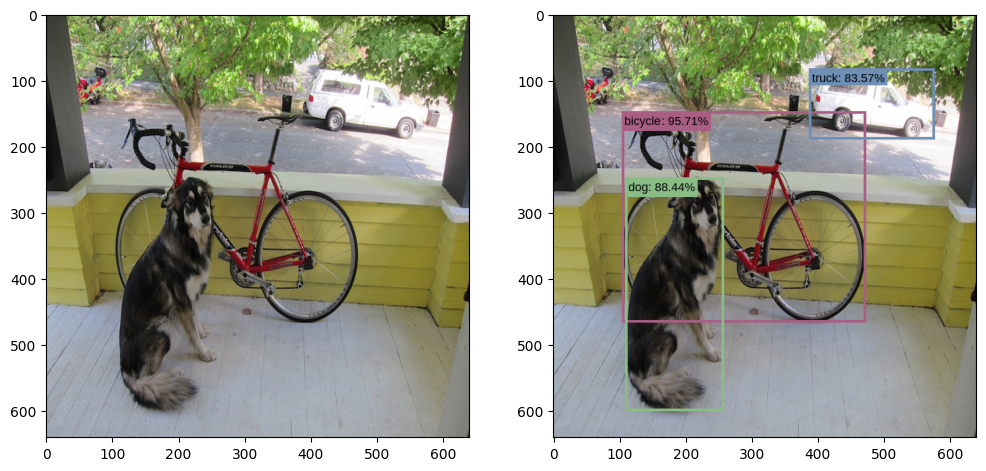

In [6]:
input_data = {input_vstream_info.name: np.array([im_np]).astype(np.float32)}

with InferVStreams(network_group, input_vstreams_params, output_vstreams_params) as infer_pipeline:
    with network_group.activate(network_group_params):
        infer_results = infer_pipeline.infer(input_data)

        processed_results = post_nms_infer(infer_results, "yolov8l/yolov8_nms_postprocess")
        bbox_image = post_process(processed_results, im, 0, 640, 640)

        fig = plt.figure(figsize=(12, 6))
        ax1 = fig.add_subplot(121)
        ax1.imshow(im_np)
        ax2 = fig.add_subplot(122)
        ax2.imshow(bbox_image)